This  is  the notebook that produces the final output we used for the presentation
All code  can be found here

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy

from time import time
from skimage import data
from skimage.feature import match_descriptors, plot_matches, SIFT, ORB
from skimage.color import rgb2gray
from skimage.measure import ransac
from skimage.transform import EuclideanTransform, warp


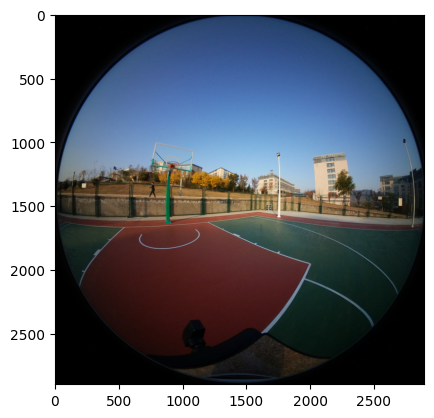

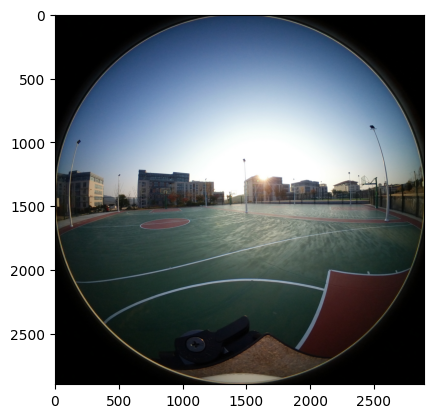

In [15]:
# Display of input 

im = np.array(Image.open("360_0770.JPG"))/255.
ima = im[:,:im.shape[1]//2]
imb = im[:,im.shape[1]//2:]


plt.imshow(ima)
plt.show()

plt.imshow(imb)
plt.show()

In [16]:
# helper  formulas for equirectangular  projection

def get_grid(im):
    h, w = im.shape[:2]
    x = np.arange(w)
    y = np.arange(h)
    x_prime = (2 * x / w - 1)
    y_prime = (2 * y / h - 1)
    grid1, grid2 = np.meshgrid(y_prime, x_prime)
    return grid1.ravel(), grid2.ravel()

def fisheye2d_to_vector3d(aperture, x, y):
    r = np.linalg.norm(np.stack([x, y]), axis=0)
    phi = r * (aperture*np.pi/180) / 2
    theta = np.arctan2(y, x)
    return r, phi, theta


def vector3d_to_latlon(r, phi, theta):
    P_y = r * np.cos(phi)
    P_z = r * np.sin(phi) * np.sin(theta)
    P_x = r * np.sin(phi) * np.cos(theta)
    longitude = np.arctan2(P_y, P_x)
    latitude = np.arctan2(P_z, np.sqrt(P_x**2 + P_y**2))
    return longitude, latitude


def latlon_to_equirectangular(longitude, latitude):
    x = longitude / np.pi
    y =  2 * latitude / np.pi
    x = ((x + 1) % 2) -1 
    y = ((y + 1) % 2) -1 
    return x, y


In [17]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# find correct FoV
def get_descriptor_distance(a, b, plot=True):
    a = rgb2gray(a)
    b = rgb2gray(b)
    descriptor_extractor = ORB()

    descriptor_extractor.detect_and_extract((a))
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract((b))
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                                  cross_check=True)
    
    
    matches1 = keypoints1[matches12[:,0]]
    matches2 = keypoints2[matches12[:,1]]    
    print(matches12.shape)
    
    
    if plot:
        fig, ax = plt.subplots()
        plot_matches(ax, a, b, keypoints1, keypoints2, matches12)
        plt.show()
        
        fig, ax = plt.subplots()
        ax.imshow(a)
        for match1, match2 in zip(matches1, matches2):
            plt.plot([match1[1],match2[1]], [match1[0],match2[0]], color=
                    'red')
        plt.show()

    
    return (np.abs(matches1 - matches2)).mean(), len(matches12)


# create equirectangular projection
def make_equirectangular(ima, imb, aperture, res):
    y_size = res * int(aperture/180.)
    x_size = res * 3.6

    # y_size = 2736
    # x_size = 5472

    lambda_0 = -np.pi/2
    y_grid, x_grid = get_grid(ima)
    
    r, phi, theta = fisheye2d_to_vector3d(aperture, y_grid, x_grid)
    
    ind = r<1
    longitude, latitude = vector3d_to_latlon(r[ind], phi[ind], theta[ind])
    
    longitude_a = longitude + lambda_0
    longitude_b = longitude - lambda_0

    equirectangular_x_a, equirectangular_y = latlon_to_equirectangular(longitude_a, latitude)
    equirectangular_x_b, equirectangular_y = latlon_to_equirectangular(longitude_b, latitude)
    

    render_grid = tuple(np.mgrid[-1:1:complex(0, y_size), -1:1:complex(0, x_size)])
    
    im_out_a = scipy.interpolate.griddata(
      np.stack([equirectangular_y, equirectangular_x_a]).T, ima.reshape(-1, 3)[ind], render_grid, method='nearest')
    
    im_out_b = scipy.interpolate.griddata(
      np.stack([equirectangular_y, equirectangular_x_b]).T, imb.reshape(-1, 3)[ind], render_grid, method='nearest')
    
    return im_out_a, im_out_b



In [18]:
# equirectangular projection with brightness adjustments

def make_equirectangular_and_blended_and_get_overlaps(ima, imb, aperture, res, return_parts=False):
    im_out_a, im_out_b = make_equirectangular(ima, imb, aperture, res)
    # y_size = res * int(aperture/180.)
    # x_size = res * 3.6

    y_size = 2736
    x_size = 5472

    mask = np.ones_like(im_out_a[:,:,:1])

    deg90 = x_size/4
    deg270 = 3 * x_size/4
    mask[:,:int(deg90-(aperture-180)/720)] = 0
    mask[:,int(deg270+(aperture-180)/720):] = 0

    begin90 = int(deg90-x_size * (aperture-180)/720)
    end90 = int(deg90+x_size * (aperture-180)/720)

    begin270 = int(deg90-x_size * (aperture-180)/720)
    end270 = int(deg90+x_size * (aperture-180)/720)


    
    image_a_left = im_out_a[:,begin90:end90]
    image_b_left = im_out_b[:,begin90:end90]
    image_a_right = im_out_a[:,begin270:end270]
    image_b_right = im_out_b[:,begin270:end270]
    
    mask = np.ones_like(im_out_a[:,:,:1])

    deg90 = x_size/4
    deg270 = 3 * x_size/4
    x_size = x_size
    mask[:,:int(deg90-(aperture-180)/720)] = 0
    mask[:,int(deg270+(aperture-180)/720):] = 0

    begin90 = int(deg90-x_size * (aperture-180)/720)
    end90 = int(deg90+x_size * (aperture-180)/720)

    begin270 = int(deg270-x_size * (aperture-180)/720)
    end270 = int(deg270+x_size * (aperture-180)/720)

    mask = np.ones_like(im_out_a[:,:,:1])

    mask[:,:int(deg90)] = 0
    mask[:,int(deg270):] = 0

    linsp = np.linspace(0, 1, int(x_size * (aperture-180)/360)).reshape(-1, 1)
    mask[:,begin90:begin90 + len(linsp)] = linsp
    mask[:,begin270:begin270 + len(linsp)] = 1 - linsp
    
    
    blended = (mask * im_out_a + (1 - mask) * im_out_b)
    if not return_parts:
        return im_out_a, im_out_b, blended
    image_a_left = im_out_a[:,begin90:end90]
    image_b_left = im_out_b[:,begin90:end90]
    blended_left = blended[:,begin90:end90]
    image_a_right = im_out_a[:,begin270:end270]
    image_b_right = im_out_b[:,begin270:end270]
    blended_right = blended[:,begin270:end270]
    return im_out_a, im_out_b, blended, image_a_left, image_b_left, blended_left, image_a_right, image_b_right, blended_right



In [ ]:
### This code computes the optimal FoV
"""distances = {}
num_matches = {}



for aperture in np.arange(191, 193, 0.05):
    res = 2000

    begin_t = time()


    im_out_a, im_out_b, blended, image_a_left, image_b_left, blended_left, image_a_right, image_b_right, blended_right = make_equirectangular_and_blended_and_get_overlaps(ima, imb, aperture, res, return_parts=True)


    
    
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(5, 12))
    scale = np.linspace(0, 1, image_a_left.shape[1]).reshape(1, -1, 1)
    ax[0][0].set_title(str(aperture)+"Image a")
    ax[0][0].imshow(image_a_left)
    ax[0][0].axis('off')
    ax[0][1].set_title("Image b")
    ax[0][1].imshow(image_b_left)
    ax[0][1].axis('off')
    ax[0][2].set_title("Blended")
    ax[0][2].imshow(blended_left)
    ax[0][2].axis('off')
    ax[0][3].set_title("Err")
    ax[0][3].imshow(np.abs(image_a_left - image_b_left).mean(axis=2))
    ax[0][3].axis('off')
    
    ax[1][0].set_title("Image a")
    ax[1][0].imshow(image_a_right)
    ax[1][0].axis('off')
    ax[1][1].set_title("Image b")
    ax[1][1].imshow(image_b_right)
    ax[1][1].axis('off')
    ax[1][2].set_title("Blended")
    ax[1][2].imshow(blended_right)
    ax[1][2].axis('off')
    ax[1][3].set_title("Err")
    ax[1][3].imshow(np.abs(image_a_right - image_b_right).mean(axis=2))
    ax[1][3].axis('off')

    plt.show()
    
    
    distance, num_match = get_descriptor_distance(image_a_left, image_b_left)
    distance2, num_match2 = get_descriptor_distance(image_a_right, image_b_right)
    
    distances[aperture] = distance + distance2
    num_matches[aperture] = num_match + num_match2
    
    plt.plot(distances.keys(), distances.values())
    plt.show()
"""

In [ ]:
"""fig, ax1 = plt.subplots()
ax1.plot(distances.keys(), distances.values())
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_xlabel('FoV (degrees)')
ax1.set_ylabel('L1 Distance of Matched Features', color="tab:blue")
for i in range(186, 197):
    ax1.axvline(i, color='gray', alpha=0.2)
ax2 = ax1.twinx()

ax2.plot(num_matches.keys(), num_matches.values(), color='tab:red')
ax2.set_ylabel('Number of matches', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.show()

"""

In [17]:
#all_fisheye_images = []
#for dir_ in [x for x in os.listdir(".") if "fisheye" in x and not "7z" in x]:
#    for fi in os.listdir(dir_):
#        if not "." in fi:
#            for img in [x for x in os.listdir(dir_ +"/"+ fi) if ".JPG" in x]:
#                all_fisheye_images.append(dir_ + "/" + fi + "/" + img)
#print(all_fisheye_images)

['fisheye/B2/360_1744.JPG', 'fisheye/B2/360_1745.JPG', 'fisheye/B2/360_1742.JPG', 'fisheye/B2/360_1743.JPG', 'fisheye/G1/360_1765.JPG', 'fisheye/G1/360_1764.JPG', 'fisheye/G1/360_1766.JPG', 'fisheye/G1/360_1767.JPG', 'fisheye/R/360_1824.JPG', 'fisheye/R/360_1825.JPG', 'fisheye/R/360_1827.JPG', 'fisheye/R/360_1826.JPG', 'fisheye/U/360_1839.JPG', 'fisheye/U/360_1838.JPG', 'fisheye/U/360_1836.JPG', 'fisheye/U/360_1837.JPG', 'fisheye/I/360_1787.JPG', 'fisheye/I/360_1786.JPG', 'fisheye/I/360_1784.JPG', 'fisheye/I/360_1785.JPG', 'fisheye/N/360_1810.JPG', 'fisheye/N/360_1807.JPG', 'fisheye/N/360_1809.JPG', 'fisheye/N/360_1808.JPG', 'fisheye/T/360_1835.JPG', 'fisheye/T/360_1834.JPG', 'fisheye/T/360_1833.JPG', 'fisheye/T/360_1832.JPG', 'fisheye/S/360_1828.JPG', 'fisheye/S/360_1829.JPG', 'fisheye/S/360_1830.JPG', 'fisheye/S/360_1831.JPG', 'fisheye/A/360_1735.JPG', 'fisheye/A/360_1734.JPG', 'fisheye/A/360_1736.JPG', 'fisheye/A/360_1737.JPG', 'fisheye/F/360_1759.JPG', 'fisheye/F/360_1762.JPG', 'fi

In [ ]:
### THIS CODE COMPUTES THE LUMINANCES!
"""luminances = {}
aperture = 192.6
for img_path in all_fisheye_images:
    begin_t = time()
    
    im = np.array(Image.open(img_path))/255.
    ima = im[:,:im.shape[1]//2]
    imb = im[:,im.shape[1]//2:]
    
    im_out_a, im_out_b, blended = make_equirectangular_and_blended_and_get_overlaps(ima, imb, aperture, 500)
    
    fig, ax = plt.subplots(nrows=3, figsize=((8, 8)))
    ax[0].set_title("Blended Image")
    ax[0].axis('off')
    ax[0].imshow(blended)

    from skimage import io, color
    lab = color.rgb2lab(blended)
    ax[1].set_title("L*-Channel")
    ax[1].imshow(lab[:,:,0])
    ax[1].axis('off')

    luminance = np.median(lab[:,:,0],axis=0)
    ax[2].set_title("L*-Channel (median)")
    ax[2].plot(luminance)
    ax[2].set_xlim(0, 1800)

    plt.tight_layout()
    plt.show()
    luminances[img_path] = luminance
"""

In [7]:
import json

lum = json.load(open("luminances_saved.json","r"))
luminances = {k:np.array(v) for k,v in lum.items()}

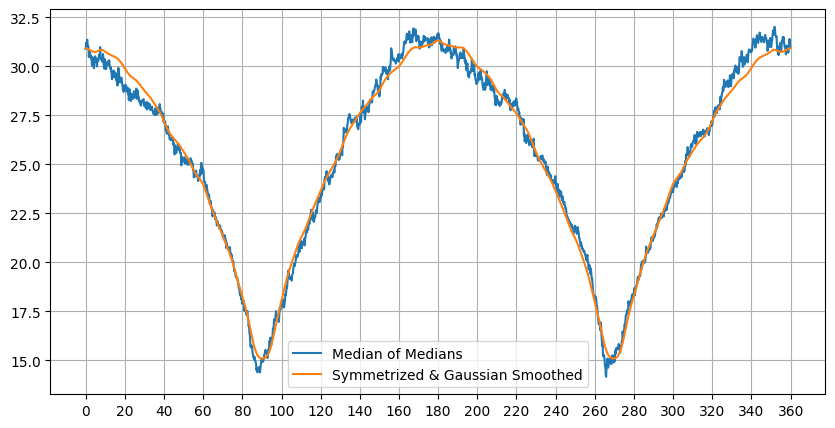

In [8]:
import scipy



fig, ax = plt.subplots(figsize=(10, 5))

raw = np.median(np.stack(list(luminances.values())), axis=0)
smoothed = scipy.ndimage.gaussian_filter1d(raw/2 + raw[::-1]/2, 9)
plt.plot(raw, label='Median of Medians')
plt.plot(smoothed, label='Symmetrized & Gaussian Smoothed')
plt.xticks(range(0, 1801, 100), labels=range(0, 361, 20))
plt.grid()
plt.legend()


In [ ]:
# increase brigthness with measured luminances

def increase_brightness(ima, imb):
    aperture = 192.6
    begin_t = time()

    ima = im[:,:im.shape[1]//2]
    imb = im[:,im.shape[1]//2:]

    im_out_a, im_out_b, blended = make_equirectangular_and_blended_and_get_overlaps(ima, imb, aperture, 500)

    fig, ax = plt.subplots(nrows=3, figsize=((8, 8)))
    ax[0].set_title("Original")
    ax[0].axis('off')
    ax[0].imshow(blended)

    from skimage import io, color
    lab = color.rgb2lab(blended)
    lab_adjusted = np.copy(lab)
    lab_adjusted[:,:,0] += smoothed.max() - smoothed.reshape(1, -1)
    rgb_adjusted = color.lab2rgb(lab_adjusted)
    plt.imsave("FINAL_buena_resolucion.png", rgb_adjusted)

    ax[1].set_title("Brightness-Adjusted")
    ax[1].axis('off')
    ax[1].imshow(rgb_adjusted)

    luminance = np.median(lab[:,:,0],axis=0)
    luminance_adjusted = np.median(lab_adjusted[:,:,0],axis=0)
    ax[2].set_title("L*-Channel (median)")
    ax[2].plot(luminance,label='Original')
    ax[2].plot(luminance_adjusted,label='Adjusted')
    ax[2].legend()
    ax[2].set_xlim(0, 7000)
    plt.tight_layout()
    plt.show()
        
increase_brightness(ima, imb)